In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import PIL
PIL.PILLOW_VERSION = PIL.__version__
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


c:\Users\Usuario\.conda\envs\torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
from sklearn.metrics import confusion_matrix

# Goal

* The goal is to motivate the use of convolutional neural networks to perform tasks related to images.

* Through the notebook, I will compare the performance on a classification task of a fully connected neural network with a convolutional neural network

* I will be using the standard MNIST dataset, which contains images of handwritten numbers.

# Getting the data

* The first step is to transform an image into an element that can be fed to the neural network. Therefore, the images will be transformed into a tensor

In [5]:
transform = transforms.ToTensor()

* Load and transform the images

In [8]:
train_data = datasets.MNIST(root = './data', train = True, download = True , transform = transform)

In [7]:
test_data = datasets.MNIST(root = './data', train = False, download = True , transform = transform)

In [8]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: C:\Users\Usuario\Desktop\Data Science\udemy\data
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

In [9]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Split: test
    Root Location: ./data
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

* Exploring the data

In [10]:
type(train_data)

torchvision.datasets.mnist.MNIST

In [11]:
type(train_data[0]), len(train_data[0])

(tuple, 2)

In [12]:
type(train_data[0][0]),type(train_data[0][1])

(torch.Tensor, int)

* Each dataset element is a two-element tuple, where the first element is a tensor (the image), and the second is an integer (the label).

In [13]:
np.random.randint(len(train_data),size = 1)[0]

41245

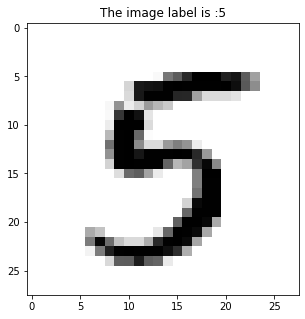

In [14]:
n = np.random.randint(len(train_data),size = 1)[0]
image,label = train_data[n]
plt.figure(figsize = (5,5))
plt.imshow(image.reshape(28,28), cmap ='gist_yarg')
plt.title(f'The image label is :{label}')
plt.show()

* It is also important to keep in mind that by using the PyTorch DataLoader with shuffle = True when the data is fed into the neural network, the data will be shuffled each epoch. That can be seen as passing a dataset slightly different on each epoch which finally will help to generalize the neural network when adjusting the weights.

In [15]:
torch.manual_seed(42)
train_loader = DataLoader(train_data, batch_size = 100, shuffle = True)
test_loader = DataLoader(test_data, batch_size = 500, shuffle = False)

In [16]:
np.set_printoptions(formatter=dict(int = lambda x:f'{x:4}'))
# We take the first batch

for images, labels in train_loader:
    break
images.shape

torch.Size([100, 1, 28, 28])

Labels:  [   1    2    8    5    2    6    9    9    9    4    0    3]


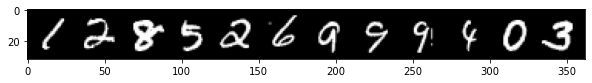

In [17]:
print('Labels: ', labels[:12].numpy())
im = make_grid(images[:12],nrow =12)
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(),(1,2,0))) # plt expect WHC and we have in images num, C,W,H

# Fully connected / Multilayer Perceptron

In [23]:
class Fully(nn.Module):
    def __init__(self,input_size = 784, output_size =10, layers = [120,84]):
        super().__init__()
        self.fc1 = nn.Linear(input_size, layers[0])
        self.fc2 = nn.Linear(layers[0],layers[1])
        self.fc3 = nn.Linear(layers[1],output_size)
    
    def forward(self,X):
        X = self.fc1(X)
        X = F.relu(X)
        X = self.fc2(X)
        X = F.relu(X)
        X = self.fc3(X)
        return F.log_softmax(X,dim = 1) #MULTI CLASS


In [24]:
torch.manual_seed(42)
model = Fully()
model

Fully(
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

*  To see the number of parameter

In [25]:
total = 0
for param in model.parameters():
    print(param.numel())
    total += param.numel()
print(f'The total number of parameters is: {total}')

94080
120
10080
84
840
10
The total number of parameters is: 105214


In [26]:
torch.manual_seed(42)
model = Fully()
criterion = nn.CrossEntropyLoss() #MUlti class
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
images.view(100,-1) # The -1 combines the three last dimensions

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

## Setting up training

In [43]:
from tqdm import trange
import time

In [85]:

startTime = time.time()
epochs = 10
torch.manual_seed(42)
model = Fully()
criterion = nn.CrossEntropyLoss() #MUlti class
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)


trainLosses = []
testLosses = []
trainCorrect = []
testCorrect = []
with trange(epochs, unit="epoch") as pbar:
    for epoch in pbar:
        trnCorrect = 0
        tstCorrect = 0
        for b , (X_train,Y_train) in enumerate(train_loader): # Each b contains 100 images
            b += 1
            yPred = model(X_train.view(100,-1))
            loss = criterion(yPred,Y_train)
            predicted = torch.max(yPred.data,1)[1] # yPred contains a tensor/vector with the probabilities for each class. We take the highest probability. We go on axis 1.
            batch_corr = (predicted==Y_train).sum()
            trnCorrect += batch_corr
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            accuracy = trnCorrect.item()*100/(100*b)
            pbar.set_postfix(loss=loss.item(), acc=accuracy)
            
        trainLosses.append(loss)
        trainCorrect.append(trnCorrect)
        
        with torch.no_grad(): #to keep track of improvement on test data
            for b, (X_test, Y_test) in enumerate(test_loader):
                y_val = model(X_test.view(500,-1))
                predicted = torch.max(y_val.data,1)[1]
                tstCorrect += (predicted== Y_test).sum()
        loss = criterion(y_val, Y_test)
        testLosses.append(loss)
        testCorrect.append(tstCorrect)
    
    
totalTime = time.time() - startTime
print(f'Duration: {totalTime/60} mins')

100%|██████████| 10/10 [02:17<00:00, 13.76s/epoch, acc=99.3, loss=0.0572] 

Duration: 2.2939032951990765 mins


## Evaluating the performance

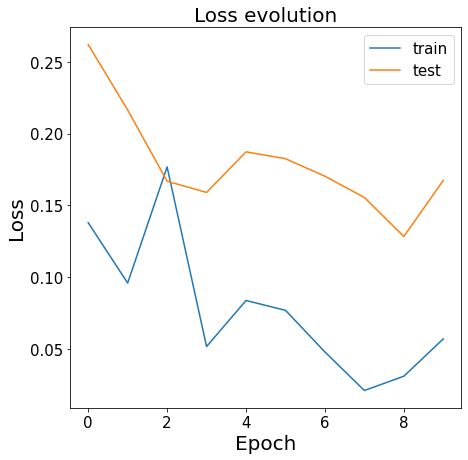

In [73]:
plt.figure(figsize=(7,7))
plt.plot([n.item() for n in trainLosses], label = 'train')
plt.plot([n.item() for n in testLosses], label = 'test')
plt.title('Loss evolution', size = 20)
plt.xlabel('Epoch', size = 20)
plt.ylabel('Loss', size = 20)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.legend(fontsize = 15)
plt.show()

In [74]:
train_acc = [t/600 for t in trainCorrect]

In [75]:
test_acc = [t/100 for t in testCorrect]

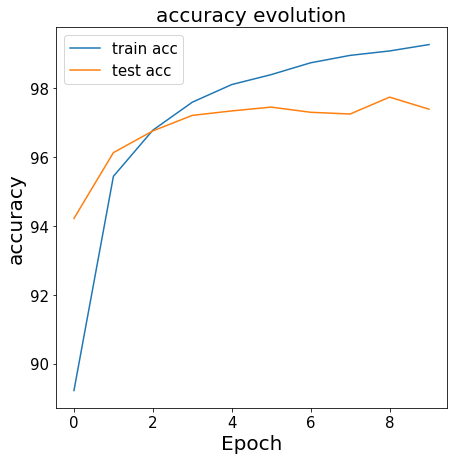

In [77]:
plt.figure(figsize=(7,7))
plt.plot(train_acc, label = 'train acc')
plt.plot(test_acc, label = 'test acc')
plt.title('accuracy evolution', size = 20)
plt.xlabel('Epoch', size = 20)
plt.ylabel('accuracy', size = 20)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.legend(fontsize = 15)
plt.show()

Because the test data has never been seen by the neural network, it reaches a maximum accuracy and it flats afterwards.

## How do I load new data in my model?

In [84]:
test_load_all = DataLoader(test_data, batch_size = 10_000, shuffle = False)
with torch.no_grad():
    correct = 0
    for X_test,Y_test in test_load_all:
        y_val = model(X_test.view(len(X_test),-1))
        predicted = torch.max(y_val,1)[1]
        correct += (predicted== Y_test).sum()
    

In [88]:
print(f'Total accuracy: {100*correct.item()/len(test_data)} %')

Total accuracy: 97.38 %


In [90]:
confusion_matrix(predicted.view(-1), Y_test.view(-1))

array([[  49,    0,    0,    0,    0,    1,    0,    0,    0,    0],
       [   0,   60,    0,    0,    1,    0,    0,    0,    0,    0],
       [   0,    0,   44,    0,    3,    0,    0,    0,    0,    0],
       [   1,    0,    1,   51,    0,    0,    1,    0,    0,    0],
       [   0,    0,    0,    0,   45,    0,    0,    0,    0,    1],
       [   0,    0,    0,    0,    0,   37,    0,    0,    0,    0],
       [   0,    0,    1,    0,    0,    3,   48,    0,    0,    0],
       [   0,    0,    1,    0,    1,    0,    0,   59,    0,    5],
       [   0,    0,    1,    1,    0,    0,    0,    0,   48,    1],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,   36]],
      dtype=int64)

# CNNs

## Introduction

ANNs drawbacks:
* A large number of parameters (100k) are required for a tiny image (28x28 pixels).
* All the information about the 2D relations is lost.
* ANN will perform better when the images are similar, for instance, the MNIST data set but with off-centre digits.

CNN advantages:
* CNN reduce parameter by local connectivity (only a subset of neurons get  connected)
* The local connectivity can be seen as filters


## getting the dataset

In [3]:
transform = transforms.ToTensor()
train_data = datasets.MNIST(root = './data', train = True, download = True , transform = transform)
test_data = datasets.MNIST(root = './data', train = False, download = True , transform = transform)

In [10]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: ./data
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

In [11]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Split: test
    Root Location: ./data
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

In [4]:
train_loader = DataLoader(train_data,batch_size = 10, shuffle = True)
test_loader = DataLoader(test_data,batch_size = 10, shuffle = False)

## Elements to define in a convolutional neural network

* in_channels: color channels, 1 may mean gray scale image
* out_channels: It can be understood as the number of filters to apply
* kernel_size: The size of each filter
* stride: The number of pixels that we are moving the kernels each time
* padding: By default 0

In [5]:
conv = nn.Conv2d(1,6,3,1)#out putt
conv2 = nn.Conv2d(6,16,3,1)# Equal to input of the next layer

## Convolutional Class

In [5]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,6,3,1)
# Since the padding is cero, we lose a pixel in each border. 
# Therefore, after the first convolutional layer, the image is 26x26
# After passing by max pooling layer with a kernel = 2 and stride = 2, the image size will be 13x13
        self.conv2 = nn.Conv2d(6,16,3,1)
# After 2nd conv we lose a pixel at each border, therefore the output image will be 11x11
# After 2nd Max pool layer with a kernel = 2 and stride = 2, we pass to 11/2 = 5.5-- 5 
        self.fc1 = nn.Linear(5*5*16,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10) # we have 10 classes
    def forward(self,X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X,2,2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X,2,2)
        X = X.view(-1,16*5*5)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X,dim=1)



In [7]:
torch.manual_seed(42)
model = ConvNet()
model

ConvNet(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [8]:
total = 0
for param in model.parameters():
    print(param.numel())
    total+= param.numel()
print(f'The total number of parameters is: {total}')

54
6
864
16
48000
120
10080
84
840
10
The total number of parameters is: 60074


The ANN had almost 110k parameters and the convolutional neural network has about 60k parameters. Therefore, we cut almost by half the number of parameters.

In [6]:
from tqdm import trange
import time

In [7]:
torch.manual_seed(42)
model = ConvNet()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

epochs = 5
trainLosses = []
testLosses = []
trainCorrect = []
testCorrect = []

startTime = time.time()
with trange(epochs, unit="epoch") as pbar:
    for epoch in pbar:
        trn_correct = 0
        tst_correct = 0
        for b, (X_train, Y_train) in enumerate(train_loader):
            b = b+1
            y_pred = model(X_train)
            loss = criterion(y_pred,Y_train)
            predicted = torch.max(y_pred.data,1)[1]
            batch_corr = (predicted == Y_train).sum()
            trn_correct += batch_corr
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            accuracy = trn_correct.item()*100/(10*b)
            pbar.set_postfix(loss=loss.item(), acc=accuracy)
        trainLosses.append(loss)
        trainCorrect.append(trn_correct)

        with torch.no_grad():
            for b, (X_test, Y_test) in enumerate(test_loader):
                y_val = model(X_test)
                predicted = torch.max(y_val.data,1)[1]
                tst_correct += (predicted == Y_test).sum()
        loss = criterion(y_val, Y_test)
        testLosses.append(loss)
        testCorrect.append(tst_correct)
        
totalTime = time.time() - startTime
print(f'Duration: {totalTime/60} mins')

100%|██████████| 5/5 [06:20<00:00, 76.14s/epoch, acc=9.91, loss=0.00197] 

Duration: 6.345368218421936 mins


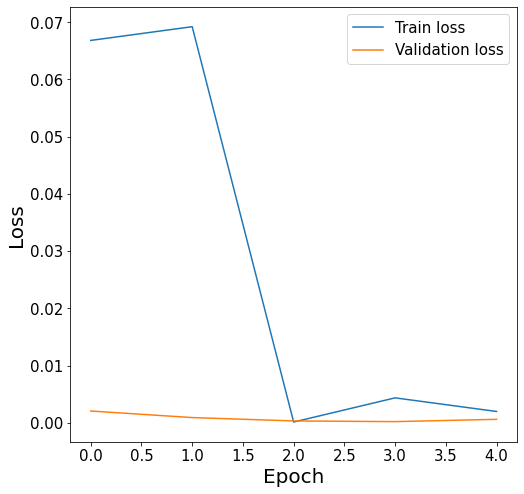

In [11]:
plt.figure(figsize=(8,8))
plt.plot([f.item() for f in trainLosses], label = 'Train loss')
plt.plot(testLosses, label ='Validation loss')
plt.xlabel('Epoch', size = 20)
plt.ylabel('Loss', size = 20)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.legend(fontsize = 15)
plt.show()

# CNN CIFAR-10 dataset (dealing with colors)

## Loading the data

In [3]:
transform = transforms.ToTensor()
train_data = datasets.CIFAR10(root = './data', train = True, download = True, transform = transform)
test_data = datasets.CIFAR10(root = './data', train = False, download = True, transform = transform)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Split: train
    Root Location: ./data
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

In [16]:
test_data

Dataset CIFAR10
    Number of datapoints: 10000
    Split: test
    Root Location: ./data
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

In [4]:
torch.manual_seed('42')
train_loader = DataLoader(train_data,batch_size = 10, shuffle = True)
test_loader = DataLoader(test_data,batch_size = 10, shuffle = False)

In [5]:
class_names = ['plane','car','bird','cat','deer','dog','frog','horse','ship','truck']

In [7]:
for images, labels in train_loader:
    break
labels

tensor([6, 0, 4, 1, 2, 7, 9, 4, 7, 8])

labels: [6 0 4 1 2 7 9 4 7 8]
Class: frog plane deer car bird horse truck deer horse ship


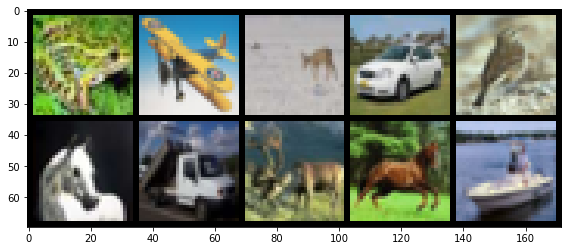

In [44]:
print('labels:', labels.numpy())
print('Class:', *[class_names[i] for i in labels])
im = make_grid(images,nrow = 5)
plt.figure(figsize =(10,4))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

## Preparing the class

In [45]:
images[0].shape

torch.Size([3, 32, 32])

In [50]:
Step1 =(32-2)/2

# padding = 0 we lose the borders
# divided by 2, because max pooling 2x2
(Step1-2)/2 #rounded down, because we cannot guess the information

6.5

In [6]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,6,3,1) #As a difference with grey scale images, color images have three entry channels
        self.conv2 = nn.Conv2d(6,16,3,1)
        self.fc1 = nn.Linear(6*6*16,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X,2,2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X,2,2)
        X = X.view(-1,6*6*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [19]:
for param in model.parameters():
    print(param.numel())

450
6
864
16
69120
120
10080
84
840
10


In [7]:
from tqdm import trange
import time

In [8]:
# All this code is just the same as for MNIST dataset
torch.manual_seed(42)
model = ConvNet()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 10
trainLosses = []
testLosses = []
trainCorrect = []
testCorrect = []

startTime = time.time()
with trange(epochs, unit="epoch") as pbar:
    for epoch in pbar:
        trn_correct = 0
        tst_correct = 0

        for b, (X_train, Y_train) in enumerate(train_loader):
            b = b+1
            y_pred = model(X_train)
            loss = criterion(y_pred,Y_train)
            predicted = torch.max(y_pred.data,1)[1]
            batch_corr = (predicted == Y_train).sum()
            trn_correct += batch_corr
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            accuracy = trn_correct.item()*100/(10*b)
            pbar.set_postfix(loss=loss.item(), acc=accuracy)
        trainLosses.append(loss)
        trainCorrect.append(trn_correct)

        with torch.no_grad():
            for b, (X_test, Y_test) in enumerate(test_loader):
                y_val = model(X_test)
                predicted = torch.max(y_val.data,1)[1]
                tst_correct += (predicted == Y_test).sum()
        loss = criterion(y_val, Y_test)
        testLosses.append(loss)
        testCorrect.append(tst_correct)
        
totalTime = time.time() - startTime
print(f'Duration: {totalTime/60} mins')


100%|██████████| 10/10 [11:12<00:00, 67.25s/epoch, acc=67.7, loss=0.679]

Duration: 11.208980520566305 mins


In [9]:
torch.save(model.state_dict(),'./models/cnnCifar10.pt')

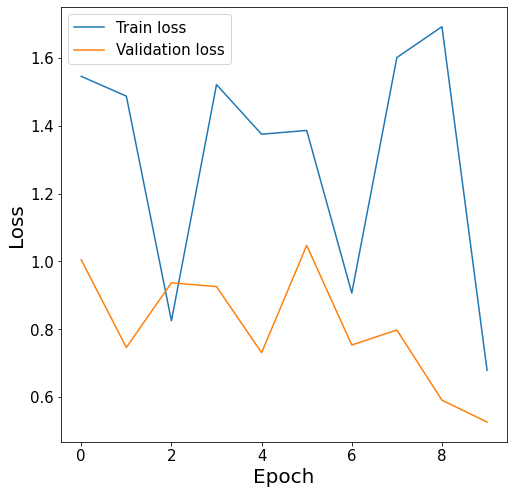

In [10]:
plt.figure(figsize=(8,8))
plt.plot([f.item() for f in trainLosses], label = 'Train loss')
plt.plot(testLosses, label ='Validation loss')
plt.xlabel('Epoch', size = 20)
plt.ylabel('Loss', size = 20)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.legend(fontsize = 15)
plt.show()

In this case, longer training would be required to start to observe a consistent trend between train and validation loss 

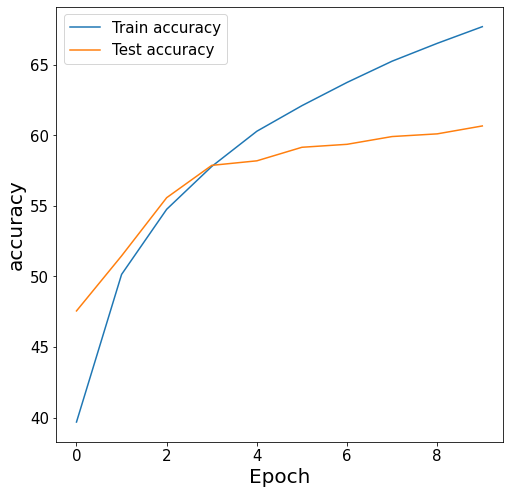

In [19]:
plt.figure(figsize=(8,8))
plt.plot([f.item()/500 for f in trainCorrect], label = 'Train accuracy')
plt.plot([f.item()/100 for f in testCorrect], label = 'Test accuracy')
plt.xlabel('Epoch', size = 20)
plt.ylabel('accuracy', size = 20)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.legend(fontsize = 15)
plt.show()

In [3]:
import seaborn as sns
import pandas as pd

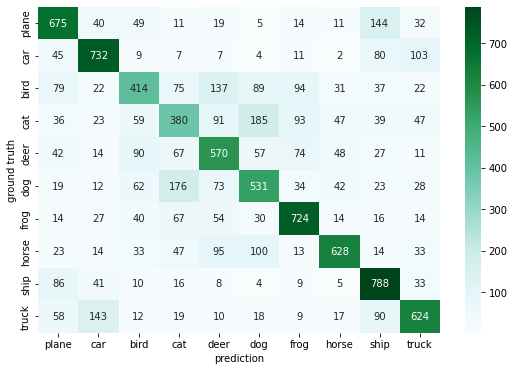

In [23]:
test_load_all = DataLoader(test_data, batch_size =10_000, shuffle = False)

with torch.no_grad():
    correct = 0
    for X_test, Y_test in test_load_all:
        y_val = model(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == Y_test).sum()
arr = confusion_matrix(Y_test.view(-1),predicted.view(-1))
dfCm = pd.DataFrame(arr, class_names,class_names)
plt.figure(figsize =(9,6))
sns.heatmap(dfCm, annot =True, fmt = 'd', cmap = 'BuGn')
plt.xlabel('prediction')
plt.ylabel('ground truth')
plt.show()

# Dealing with real images 

When dealing with real images, it will be necessary in almost all cases for some sort of image normalization.  This is because we want to feed to the CNN images with the same dimensions.
Common operations that may be required are:
* Aspect ratio adjustment.
* Scaling.
* Normalization.
* Transforming to Tensor.

The datasets used up to now contain thousands of images. However, in a real environment, it may not be feasible to have or collect that many images. Therefore, one needs strategies for what is called “data augmentation”.

Data augmentation can be achieved by simple transformations like:
* Flipping images.
* Cropping images.
* …

The advantage of this procedure of data augmentation is that it will make the CNN more robust against variations in the images.


## Loading images

* https://drive.google.com/file/d/1fuFurVV8rcrVTAFPjhQvzGLNdnTi1jWZ/view

In [4]:
import os
import shutil
from PIL import Image
import warnings
from random import choice
warnings.filterwarnings('ignore')

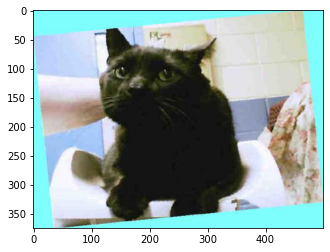

In [5]:
PATH = './data/CATS_DOGS/test/CAT/'
images = os.listdir(PATH)
imag = choice(images)
with Image.open(PATH+imag) as im:
    plt.imshow(im)

In [6]:
PATH = './data/CATS_DOGS/'
image_names = []
for folder,subfolder, filenames in os.walk(PATH):
    for img in filenames:
        image_names.append(folder+'/'+img)

I am going through all the images verifying that all of them can be open.

In [7]:
image_sizes = []
errors = []
for n,item in enumerate(image_names):
    try:
        with Image.open(item) as im:
            image_sizes.append(im.size)
    except:
        errors.append(n)

In [8]:
image_names_sizes = []
errors = []
for n,item in enumerate(image_names):
    try:
        with Image.open(item) as im:
            image_names_sizes.append([item,*im.size])
    except:
        errors.append(n)

In [9]:
print(len(image_sizes), len(errors))

24994 0


In [16]:
df = pd.DataFrame(image_names_sizes)
df[1].describe()

count    24994.000000
mean       404.493518
std        108.941802
min         42.000000
25%        323.000000
50%        448.000000
75%        500.000000
max        500.000000
Name: 1, dtype: float64

In [17]:
df[2].describe()

count    24994.000000
mean       361.037129
std         96.936811
min         33.000000
25%        302.000000
50%        375.000000
75%        421.000000
max        500.000000
Name: 2, dtype: float64

To perform some minim cleaning, I will remove the outliers based on image size. The goal is to get images of relatively the same size. That may reduce the need for resizing or cropping and losing information in the process of image normalization.

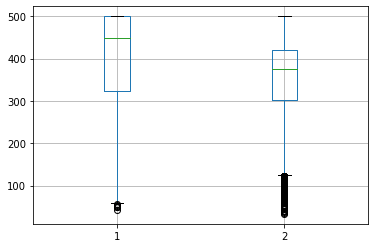

In [18]:
boxplot = df.boxplot()

In [19]:
Q1_dim0 = df[1].quantile(0.25)
Q2_dim0 = df[1].quantile(0.75)
Q1_dim1 = df[2].quantile(0.25)
Q2_dim1 = df[2].quantile(0.75)

IQR1 = Q2_dim0 - Q1_dim0
IQR2 = Q2_dim1 - Q1_dim1
filter1 = (df[1]<=(Q1_dim0-1.5*IQR1))|(df[1]>=(Q2_dim0+1.5*IQR1))
filter2 = (df[2]<=Q1_dim0-1.5*IQR2)|(df[2]>=Q2_dim0+1.5*IQR2)

In [20]:
dfoutlier = df[(filter1|filter2)].reset_index(drop = True)
dfclean = df[~(filter1|filter2)].reset_index(drop = True)
print(f'Total number of images: {len(df)}, number of outliers: {len(dfoutlier)}, Total samples: {len(dfclean)}')

Total number of images: 24994, number of outliers: 585, Total samples: 24409


In [24]:
PATH_DESTINATION = './data/CATS_DOGS/outlier/'
for n, row in dfoutlier.iterrows():
    fileName = row[0].split('/')[-1]
    shutil.move(row[0],PATH_DESTINATION+fileName)

## Image manipulation for data augmentation

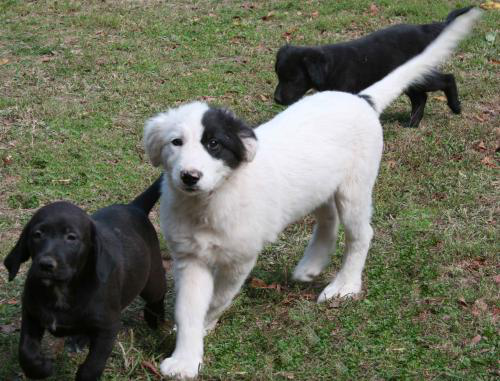

In [6]:
fileDog = './data/CATS_DOGS/train/DOG/16.jpg'
dog = Image.open(fileDog)
display(dog)

* Usually, pixel values for image at each channel have a value between 0 and 255

In [55]:
dog.getpixel((0,0))

(100, 106, 72)

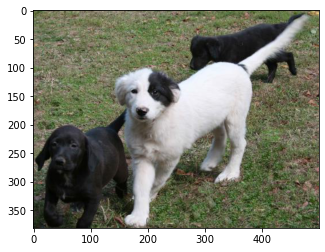

In [56]:
transform = transforms.Compose([transforms.ToTensor()])
im = transform(dog)
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

* By comparing the pixel values of the original image with the pixel values of the image which has been transformed into a tensor, one can see that the pixel values have been normalized.

In [57]:
im[:,0,0],dog.getpixel((0,0)),np.array(dog.getpixel((0,0)))/255

(tensor([0.3922, 0.4157, 0.2824]),
 (100, 106, 72),
 array([0.39215686, 0.41568627, 0.28235294]))

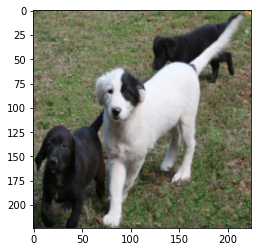

In [58]:
transform = transforms.Compose([
                        transforms.Resize((224,224)),
                        transforms.ToTensor()
                        ])
im = transform(dog)
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

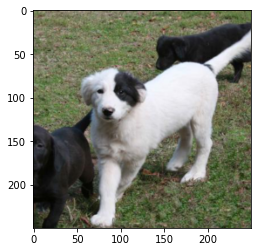

In [59]:
transform = transforms.Compose([
                        transforms.Resize(250),
                        transforms.CenterCrop(250),# This works best for centred images
                        transforms.ToTensor()
                        ])
im = transform(dog)
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

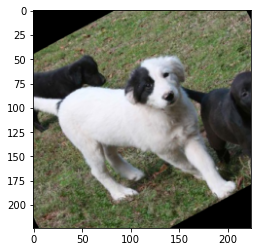

In [60]:
transform = transforms.Compose([
                        transforms.RandomHorizontalFlip(p=1),
                        transforms.RandomRotation(30),
                        transforms.Resize(224),
                        transforms.CenterCrop(224),# This works best for centred images
                        transforms.ToTensor()
                        ])
im = transform(dog)
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


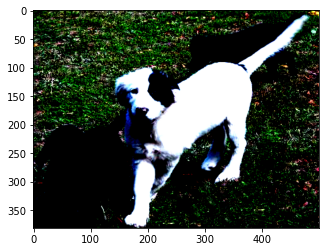

In [61]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485,0.456,0.406],std=[0.229,0.224,0.225]) # Values from research

])
im = transform(dog)
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

* To inverse the normalization

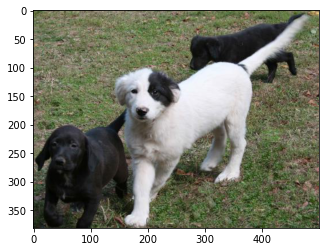

In [62]:
invNormalize = transforms.Compose([
    transforms.Normalize(mean = [-0.485/0.229,-0.456/0.224,-0.406/0.225],
                        std=[1/0.229,1/0.224,1/0.225]) # Values from research
])
invNor = invNormalize(im)
plt.imshow(np.transpose(invNor.numpy(),(1,2,0)))

## Loading data

### Transformations for train and test set

In [9]:
train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485,0.456,0.406],std=[0.229,0.224,0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485,0.456,0.406],std=[0.229,0.224,0.225])
])

In [10]:
PATH = './data/CATS_DOGS'
train_data = datasets.ImageFolder(os.path.join(PATH,'train'),transform = train_transform)
test_data = datasets.ImageFolder(os.path.join(PATH,'test'),transform = test_transform)
torch.manual_seed(42)
train_loader = DataLoader(train_data, batch_size = 10, shuffle = True)
test_loader = DataLoader(test_data, batch_size = 10, shuffle = False)
class_names = train_data.classes# the class names are taken from the subfolder names

In [11]:
len(train_data),len(test_data)

(18310, 6099)

* Lets see a batch of images

In [12]:
for images,labels in train_loader:
    break
images.shape

torch.Size([10, 3, 224, 224])

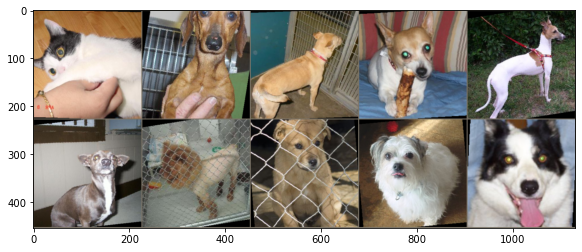

In [13]:
for images,labels in train_loader:
    break
im = make_grid(images, nrow = 5)
invNormalize = transforms.Compose([
    transforms.Normalize(mean = [-0.485/0.229,-0.456/0.224,-0.406/0.225],
                        std=[1/0.229,1/0.224,1/0.225]) # Values from research
])
invNor = invNormalize(im)
plt.figure(figsize = (12,4))
plt.imshow(np.transpose(invNor.numpy(),(1,2,0)))

### Define the model

In [81]:
(((224-2)/2)-2)/2

54.5

In [14]:
class CNNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = 3,out_channels = 6,kernel_size =3,stride = 1)
        self.conv2 = nn.Conv2d(in_channels = 6,out_channels = 16, kernel_size =3,stride =1)
        self.fc1 = nn.Linear(in_features = 54*54*16, out_features = 120)
#        self.fc2 = nn.Linear(in_features = 12_000, out_features =1_200)
        # self.fc3 = nn.Linear(in_features =1_200, out_features = 120)
        self.fc4 = nn.Linear(in_features =120, out_features = 84)
        # self.fc5 = nn.Linear(in_features =84, out_features = 40)
        self.fc6 = nn.Linear(in_features =84, out_features = 2)
        self.dropOut = nn.Dropout(0)
    def forward(self,X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X,(2,2))
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X,(2,2))
        X = X.view(-1,54*54*16)
        X = F.relu(self.fc1(X))
#        x = self.dropOut(X)
        # X = F.relu(self.fc2(X))
        # x = self.dropOut(X)
        # X = F.relu(self.fc3(X))
        # x = self.dropOut(X)
        X = F.relu(self.fc4(X))
        # X = F.relu(self.fc5(X))
        X = self.fc6(X)
        return F.log_softmax(X, dim = 1)

In [18]:
torch.manual_seed(42)
model = CNNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [94]:
CNNmodel

CNNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=46656, out_features=1200, bias=True)
  (fc3): Linear(in_features=1200, out_features=120, bias=True)
  (fc4): Linear(in_features=120, out_features=84, bias=True)
  (fc5): Linear(in_features=84, out_features=40, bias=True)
  (fc6): Linear(in_features=40, out_features=2, bias=True)
  (dropOut): Dropout(p=0.4, inplace=False)
)

In [16]:
total = 0
for paramlayer in CNNmodel.parameters():
    print(paramlayer.numel())
    total+=paramlayer.numel()
print(f'Total number of parameters is: {total}')

162
6
864
16
5598720
120
10080
84
168
2
Total number of parameters is: 5610222


In [26]:
from tqdm import trange
import time

In [15]:
# All this code is just the same as for MNIST dataset
torch.manual_seed(42)
model = CNNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
epochs = 10
trainLosses = []
testLosses = []
trainCorrect = []
testCorrect = []

#Limit the number the batches
max_trn_batch = 800  # 10 images per batch --  8_000 images in total
max_tst_batch = 300


startTime = time.time()
with trange(epochs, unit="epoch") as pbar:
    for epoch in pbar:
        trn_correct = 0
        tst_correct = 0

        for b, (X_train, Y_train) in enumerate(train_loader):
            
            # if b == max_trn_batch:
            #     break
            b = b+1
            y_pred = model(X_train)
            loss = criterion(y_pred,Y_train)
            predicted = torch.max(y_pred.data,1)[1]
            batch_corr = (predicted == Y_train).sum()
            trn_correct += batch_corr
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            accuracy = trn_correct.item()*100/(10*b)
            pbar.set_postfix(loss=loss.item(), acc=accuracy)
            
        trainLosses.append(loss)
        trainCorrect.append(trn_correct)

        with torch.no_grad():
            for b, (X_test, Y_test) in enumerate(test_loader):
                # if b == max_tst_batch:
                #     break
                y_val = model(X_test)
                predicted = torch.max(y_val.data,1)[1]
                tst_correct += (predicted == Y_test).sum()
        loss = criterion(y_val, Y_test)
        testLosses.append(loss)
        testCorrect.append(tst_correct)
        
totalTime = time.time() - startTime
print(f'Duration: {totalTime/60} mins')
torch.save(model.state_dict(),'./models/cat_dog.pt')

100%|██████████| 10/10 [1:35:17<00:00, 571.70s/epoch, acc=87.1, loss=0.421]

Duration: 95.28382013638814 mins


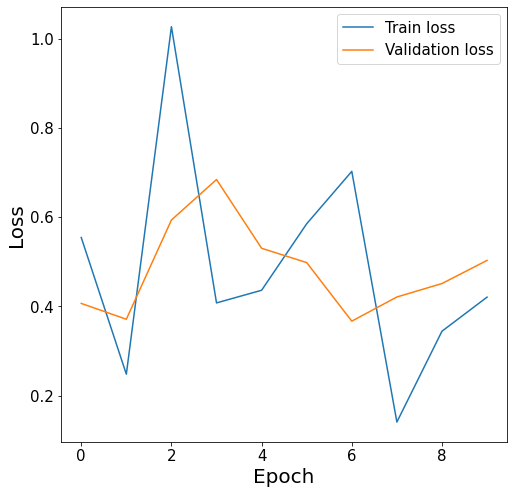

In [16]:
plt.figure(figsize=(8,8))
plt.plot([f.item() for f in trainLosses], label = 'Train loss')
plt.plot(testLosses, label ='Validation loss')
plt.xlabel('Epoch', size = 20)
plt.ylabel('Loss', size = 20)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.legend(fontsize = 15)
plt.show()

## Using pre-train models

* All pre-trained models expect the input image with a certain size and normalized in a certain way.

### AlexNet

The models from the import: "from torchvision import datasets, transforms, <b>models</b>" contains several models ready to be used 

In [19]:
AlexNetmodel = models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to C:\Users\Usuario/.cache\torch\hub\checkpoints\alexnet-owt-4df8aa71.pth
100%|██████████| 233M/233M [00:42<00:00, 5.72MB/s] 


* <b>pretrained = True</b> loads the wights

In [20]:
AlexNetmodel

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [21]:
# Freeze weights
for param in AlexNetmodel.parameters():
    param.requires_grad = False

* The model alexNet was trained to classify 1000 categories. For our case we only want to classify images into two classes: CATS and DOGS
* one can see it : (6): Linear(in_features=4096, out_features=1000, bias=True)

In [22]:
torch.manual_seed(42)
AlexNetmodel.classifier = nn.Sequential(nn.Linear(in_features=9216, out_features=4096, bias=True),
                            nn.ReLU(inplace=True),
                            nn.Dropout(p=0.5, inplace=False),
                            nn.Linear(in_features=4096, out_features=4096, bias=True),
                            nn.ReLU(inplace=True),
                            nn.Linear(in_features=4096, out_features=2, bias=True),
                            nn.LogSoftmax(dim = 1))

In [23]:
AlexNetmodel

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=4096, bias=True)
    (1): ReLU(inplace=True)
    (2): Dro

In [24]:
for param in AlexNetmodel.parameters():
    print(param.numel())

23232
64
307200
192
663552
384
884736
256
589824
256
37748736
4096
16777216
4096
8192
2


In [27]:
train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485,0.456,0.406],std=[0.229,0.224,0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485,0.456,0.406],std=[0.229,0.224,0.225])
])

In [28]:
PATH = './data/CATS_DOGS'
train_data = datasets.ImageFolder(os.path.join(PATH,'train'),transform = train_transform)
test_data = datasets.ImageFolder(os.path.join(PATH,'test'),transform = test_transform)
torch.manual_seed(42)
train_loader = DataLoader(train_data, batch_size = 10, shuffle = True)
test_loader = DataLoader(test_data, batch_size = 10, shuffle = False)
class_names = train_data.classes# the class names are taken from the subfolder names

In [29]:
torch.manual_seed(42)
AlexNetmodel = models.alexnet(pretrained=True)
AlexNetmodel.classifier = nn.Sequential(nn.Linear(in_features=9216, out_features=4096, bias=True),
                            nn.ReLU(inplace=True),
                            nn.Dropout(p=0.5, inplace=False),
                            nn.Linear(in_features=4096, out_features=4096, bias=True),
                            nn.ReLU(inplace=True),
                            nn.Linear(in_features=4096, out_features=2, bias=True),
                            nn.LogSoftmax(dim = 1))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(AlexNetmodel.classifier.parameters(), lr = 0.001)


epochs = 1 # Only one epoch. CNN weights already trained and freeze
trainLosses = []
testLosses = []
trainCorrect = []
testCorrect = []

#Limit the number the batches
max_trn_batch = 800  # 10 images per batch --  8_000 images in total
max_tst_batch = 300


startTime = time.time()
with trange(epochs, unit="epoch") as pbar:
    for epoch in pbar:
        trn_correct = 0
        tst_correct = 0

        for b, (X_train, Y_train) in enumerate(train_loader):
            
            # if b == max_trn_batch:
            #     break
            b = b+1
            y_pred =AlexNetmodel(X_train)
            loss = criterion(y_pred,Y_train)
            predicted = torch.max(y_pred.data,1)[1]
            batch_corr = (predicted == Y_train).sum()
            trn_correct += batch_corr
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            accuracy = trn_correct.item()*100/(10*b)
            pbar.set_postfix(loss=loss.item(), acc=accuracy)
            
        trainLosses.append(loss)
        trainCorrect.append(trn_correct)

        with torch.no_grad():
            for b, (X_test, Y_test) in enumerate(test_loader):
                # if b == max_tst_batch:
                #     break
                y_val = AlexNetmodel(X_test)
                predicted = torch.max(y_val.data,1)[1]
                tst_correct += (predicted == Y_test).sum()
        loss = criterion(y_val, Y_test)
        testLosses.append(loss)
        testCorrect.append(tst_correct)
        
totalTime = time.time() - startTime
print(f'Duration: {totalTime/60} mins')
torch.save(model.state_dict(),'./models/cat_dog_Alex.pt')

100%|██████████| 1/1 [49:16<00:00, 2956.53s/epoch, acc=92.4, loss=0.0116]

Duration: 49.27562027772267 mins


In [41]:
print(trainCorrect[-1].item()/(18310/100)),print(testCorrect[-1].item()/(6099/100))

92.44128891316221
91.32644695851779


(None, None)

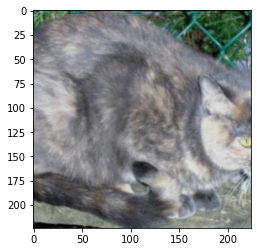

In [42]:
invNormalize = transforms.Compose([
    transforms.Normalize(mean = [-0.485/0.229,-0.456/0.224,-0.406/0.225],
                        std=[1/0.229,1/0.224,1/0.225]) # Values from research
])
image_index = 1090
invNor = invNormalize(test_data[image_index][0])

plt.imshow(np.transpose(invNor.numpy(),(1,2,0)))

In [44]:
CNNmodel = CNNetwork()
CNNmodel.load_state_dict(torch.load('./models/cat_dog.pt'))
with torch.no_grad():
    new_prediction = CNNmodel(test_data[image_index][0].view(1,3,224,224)).argmax()

class_names[new_prediction.item()]

'DOG'

In [45]:
AlexNetmodel.eval()
with torch.no_grad():
    new_prediction = AlexNetmodel(test_data[image_index][0].view(1,3,224,224)).argmax()

class_names[new_prediction.item()]

'CAT'